### Nuclear Mass Predictor with Support Vector Machines
##### November 2020
##### Jeffrey T. Kwarsick, Ph.D.
### Introduction
### References
1. <a href="url" target="https://www-nds.iaea.org/amdc/">Atomic Mass Data Center</a>
2. <a href="url" target="https://arxiv.org/abs/2004.14196">Nuclear Binding Energy Predictions based on Machine Learning</a>
3. <a href="url" target="https://arxiv.org/abs/1907.09764">Trees and Islands -- Machine learning approach to nuclear physics</a>
4. <a href="url" target="https://arxiv.org/abs/1803.03215">Deep Learning: A Tool for Computational Nuclear Physics</a>

In [31]:
import numpy as np
import pandas as pd
import math
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import scipy as sci
from scipy import stats
import time
from datetime import datetime
plt.style.use('ggplot')

##### Date Block

In [2]:
today = datetime.now()
month = today.strftime("%b")
day   = today.strftime("%d")
year  = today.strftime("%Y")
print("Today is {0} {1}, {2}".format(month, day, year))

Today is Nov 27, 2020


#### Pre-processing Data from Atomic Mass Evaluation
Data used for model training is from the **Atomic Mass Evaluation** published in Chinese Physics C (Chinese Physics C Vol. 41, No. 3 (2017) 030002).  Access to this information can be found at this <a href="url" target="https://www-nds.iaea.org/amdc/">link.</a>

- I am using the **mass16.txt** file to extract data from.
    - This file contains a myriad of information for nuclei in the dataset.  These include:
        - N-Z
        - N (neutron number) **WANT THIS**
        - Z (proton number) **WANT THIS**
        - A (mass number, N + Z)
        - EL (Element Symbol) **WANT THIS**
        - O (decay channel)
        - Mass Excess (keV) **WANT THIS**
        - Binding Energy per Nucleon (BE/A, keV) **WANT THIS**
        - $\beta$-Decay Energy (keV) **WANT THIS**
        - Atomic Mass (micro-AMUs = millionths of Atomic Mass Units) **WANT THIS**
    - Many of these values have errors associated with their values, space separated.
    - Some values such as ATOMIC MASS has a space between it's first digit and the rest of the numbers
    - Some values have non-numeric values in their value that must be removed
    - Some instances do not have values at all and must be handled as NULL or something
    - Characters to remove:
        - "#" is some kind of rounding error thing
        - "*" is an empty value

In [3]:
file = "ame2016_nuclear_masses.txt"
num_lines = sum(1 for line in open(file))
print(num_lines)

3438


In [54]:
with open(file) as f:
    content = f.readlines()
f.close()
content = [line.rstrip('\n') for line in content]

In [55]:
foo = [line.replace('#', "") if "#" in line else line for line in content]
print(len(foo))

3438


In [100]:
foo[0]

'1N-Z    N    Z   A  EL    O     MASS EXCESS       BINDING ENERGY/A        BETA-DECAY ENERGY         ATOMIC MASS'

In [63]:
tmp = re.sub(r"(?<=[0-9]{1})\s{1}(?=.+)", "", foo[2])
tmp.split()

['0',
 '1',
 '1',
 '0',
 '1',
 'n',
 '8071.31713',
 '0.00046',
 '0.0',
 '0.0',
 'B-',
 '782.347',
 '0.000',
 '1008664.91582',
 '0.00049']

In [72]:
bar = [re.sub(r"(?<=\s[0-9]{1})\s{1}(?=[0-9])", "", x) for x in foo]
bar = [re.sub(r"(?<=\s[0-9]{2})\s{1}(?=[0-9])", "", x) for x in bar]
bar = [re.sub(r"(?<=\s[0-9]{3})\s{1}(?=[0-9])", "", x) for x in bar]
print(len(bar))

3438


#### Visualizing the Data Structure
- Upon splitting the data in each line using the `.split()` function we can see that the there is a distribution in the length of the resulting lists generated from each line.  This will require some additional processing in order to have all the data fit nicely into a single dataframe
- After making this observation, I sought out look at data of variable length to see what structure I can take advantage of in order to correctly extract the data
    - Printed all instance of len(line) = 13, since there were only 4 instances
    - Created function `sample_data()` to randomly sample and look at structure of data in each line for longer lines

(array([   0.,    4., 1413., 1731.,  288.,    0.]),
 array([12, 13, 14, 15, 16, 17, 18]),
 <BarContainer object of 6 artists>)

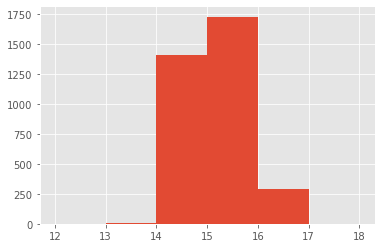

In [128]:
length_of_lines = [len(x.split()) for x in bar[2:]]
plt.hist(length_of_lines, bins=np.arange(12,19,1))

In [83]:
for i in range(len(bar)):
    if len(bar[i].split()) == 13:
        print(bar[i])

  -1    0    1    1 H          7288.97061    0.00009      0.0      0.0   B-      *                1007825.03224    0.00009
  -4    2    6    8 C         35064.268     18.243     3101.524    2.280 B-      *                8037643.042     19.584
  -4    7   11   18 Na        25037.988     93.881     6202.217    5.216 B-      *               18026879.386    100.785
   9   78   69  147 Tm       -35974.400      6.839     7948.817    0.047 B-      *              146961379.890      7.341


In [276]:
def sample_data(list_of_lines, line_length):
    """
    Given length of line.split(), return lines sampled from the data with given length
    
    Input:
        list_of_lines: (list) of strings 
        line_length: (int) of list length
        
    Output:
        lines: n lines from dataset of given length when string is split()
    """
    yarg = True
    while yarg == True:
        tmp = np.random.randint(low = 0, high=len(list_of_lines))
        if len(list_of_lines[tmp].split()) == line_length:
            print(list_of_lines[tmp])
        else:
            yarg = False

In [273]:
sample_data(bar,14)

  42  120   78  198 Pt       -29903.999      2.100     7914.150    0.011 B-   -323.219    2.059 197967896.734      2.254
  20   66   46  112 Pd       -86321.562      6.544     8520.724    0.058 B-    262.156    6.978 111907329.986      7.025
  36  111   75  186 Re       -41927.086      0.826     7981.269    0.004 B-   1072.857    0.837 185954989.419      0.886


In [275]:
sample_data(bar, 15)

  55  161  106  267 Sg   -a  115806       257        7327       1    B-  -2960     367    267124322       276


In [274]:
sample_data(bar, 16)

0 42  103   61  164 Pm    x  -38870       400        8017       2    B-   9232     499    163958271       429


#### Using Regular Expressions to Extract Element Symbol
I love the mini-game of using regular expressions in order to extract data from strings in the dataset.  After playing around on <a href="url" target="https://regex101.com/">regex101.com</a> with some sample data, the below expression can be used to extract the element symbol from each line.

In [277]:
sym = re.findall(r"(?<=\s{1})([A-Z][a-z]?|n)(?=\s)", bar[409])[0]
sym

'Ca'

In [278]:
reg = re.compile("([A-Z][a-z]?)(?=\s)")
el_sym = [re.findall(r"(?<=\s{1})([A-Z][a-z]?|n)(?=\s)", bar[i])[0] for i in range(2,len(bar))]

#### Remove first 2 lines from dataset since they contain no data, only headers for each of the columns

In [198]:
out = [bar[i].split() for i in range(2,len(bar))]

Since the data is not consistent from line to line, I need a strategy for extracting the data that I want from each line.  As it turns out, the regular expression that was used to extract the element symbol can be used to identify the indices of all instances of non-digit characters in the line.
- Left of the Element Symbol (in order from right to left) are A, Z, N, and N-Z
- Left of the B- characters (present in every line) are BE/A error, BE/A, Mass Excess error, and Mass Excess
- Right of the B- character are the Beta Decay Energy, Beta Decay Energy Error, Atomic Mass, Atomic Mass Error
    - In the event that a beta decay energy is not calculable, there is an asterisk in place of Beta Decay Energy and error, this must be handled with care

In [149]:
idxs = [i for i, item in enumerate(out[6]) if re.search(r"([A-Z][a-z]?|n)", item)]

In [153]:
tes = [[i for i, item in enumerate(out[x]) if re.search(r"([A-Z][a-z]?|n)", item)] for x in range(len(out))]

In [202]:
tes[0:10]

[[5, 10],
 [4, 9],
 [5, 10],
 [5, 10],
 [4, 9],
 [4, 10],
 [5, 6, 11],
 [4, 9],
 [4, 10],
 [5, 6, 11]]

In [321]:
A = [int(out[i][tes[i][0] - 1]) for i in range(len(tes))]
Z = [int(out[i][tes[i][0] - 2]) for i in range(len(tes))]
N = [int(out[i][tes[i][0] - 3]) for i in range(len(tes))]
N_Z = [(N[i] - Z[i]) for i in range(len(Z))]

In [322]:
BE_A            = [float(out[i][tes[i][-1] - 2]) for i in range(len(tes))]
BE_A_err        = [float(out[i][tes[i][-1] - 1]) for i in range(len(tes))]
mass_excess     = [float(out[i][tes[i][-1] - 4]) for i in range(len(tes))]
mass_excess_err = [float(out[i][tes[i][-1] - 3]) for i in range(len(tes))]

In [323]:
atomic_mass     = [float(out[i][-2]) for i in range(len(out))]
atomic_mass_err = [float(out[i][-1]) for i in range(len(out))]
atomic_mass[0:10]

[1008664.91582,
 1007825.03224,
 2014101.77811,
 3016049.28199,
 3016029.32265,
 3030775.0,
 4026431.868,
 4002603.25413,
 4027185.562,
 5035311.493]

In [324]:
beta_E, beta_E_err = [], []
for i in range(len(out)):
    if out[i][tes[i][-1]+1] == "*":
        beta_E.append(None)
        beta_E_err.append(None)
    else:
        beta_E.append(float(out[i][tes[i][-1]+1]))
        beta_E_err.append(float(out[i][tes[i][-1]+2]))

In [320]:
len(beta_E_err)

3436

In [325]:
test_df = pd.DataFrame(list(zip(el_sym, Z, N, A, N_Z, BE_A, BE_A_err, mass_excess, mass_excess_err,
                               atomic_mass, atomic_mass_err, beta_E, beta_E_err)))
test_df.columns = ["Element_Symbol", "Z", "A", "N", "N-Z", "BE_A", "BE_A_err", "MassExcess", "MassExcessErr",
                  "AtomicMass", "AtomicMassErr", "BetaDecayE", "BetaDecayE_err"]
test_df.to_csv("cleaned_NuclearData.csv", index=False)

In [527]:
test_df.describe()

,Z,A,N,N-Z,BE_A,BE_A_err,MassExcess,MassExcessErr,AtomicMass,AtomicMassErr,BetaDecayE,BetaDecayE_err
count,3436.000000,3436.000000,3436.000000,3436.000000,3436.000000,3436.000000,3436.000000,3436.000000,3.436000e+03,3436.000000,3141.000000,3141.000000
mean,57.857392,82.034051,139.891444,24.176659,7959.806728,1.838921,-24144.120957,123.588536,1.398655e+08,132.654412,-100.991337,155.851106
std,27.809406,43.293558,70.599410,17.638417,738.982115,15.031735,56200.705700,197.547987,7.063095e+07,212.043923,8063.858254,239.079983
min,0.000000,0.000000,1.000000,-8.000000,-2267.000000,0.000000,-91652.853000,0.000000,1.007825e+06,0.000000,-28945.000000,0.000000
25%,36.000000,47.000000,84.000000,10.000000,7730.734250,0.024000,-65400.443000,3.005750,8.392781e+07,3.226500,-5356.454000,6.406000
50%,58.000000,81.000000,139.000000,22.000000,8073.000000,0.094000,-39335.024000,14.474000,1.389127e+08,15.537500,-858.530000,27.916000
75%,80.000000,114.000000,194.000000,38.000000,8367.375000,1.000000,1172.301000,196.000000,1.939668e+08,211.000000,4700.000000,236.000000
max,118.000000,177.000000,295.000000,61.000000,8794.553000,667.000000,201512.000000,2003.000000,2.952163e+08,2150.000000,31687.000000,2003.000000


In [326]:
test_df.query("Element_Symbol == 'Ni'")

,Element_Symbol,Z,A,N,N-Z,BE_A,BE_A_err,MassExcess,MassExcessErr,AtomicMass,AtomicMassErr,BetaDecayE,BetaDecayE_err
402,Ni,28,20,48,-8,7265.000,10.000,16793.000,502.000,4.801803e+07,538.000,NaN,NaN
415,Ni,28,21,49,-7,7457.000,12.000,8200.000,600.000,4.900880e+07,644.000,NaN,NaN
427,Ni,28,22,50,-6,7716.000,10.000,-4120.000,500.000,4.999558e+07,537.000,NaN,NaN
439,Ni,28,23,51,-5,7875.000,10.000,-11900.000,500.000,5.098722e+07,537.000,NaN,NaN
450,Ni,28,24,52,-4,8079.000,8.000,-22330.000,400.000,5.197603e+07,429.000,-20049.000,721.000
462,Ni,28,25,53,-3,8217.074,0.475,-29630.824,25.150,5.296819e+07,27.000,-16361.000,501.000
473,Ni,28,26,54,-2,8393.032,0.086,-39278.308,4.657,5.395783e+07,5.000,-17868.000,400.000
485,Ni,28,27,55,-1,8497.320,0.013,-45335.849,0.719,5.495133e+07,0.771,-13700.449,155.561
497,Ni,28,28,56,0,8642.779,0.008,-53907.539,0.422,5.594213e+07,0.452,-15264.511,14.910
509,Ni,28,29,57,1,8670.933,0.010,-56083.833,0.582,5.693979e+07,0.624,-8774.947,0.439


In [500]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)
from keras import layers
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

import keras.backend as K
K.set_image_data_format('channels_last')

2.3.1


In [308]:
import seaborn as sns

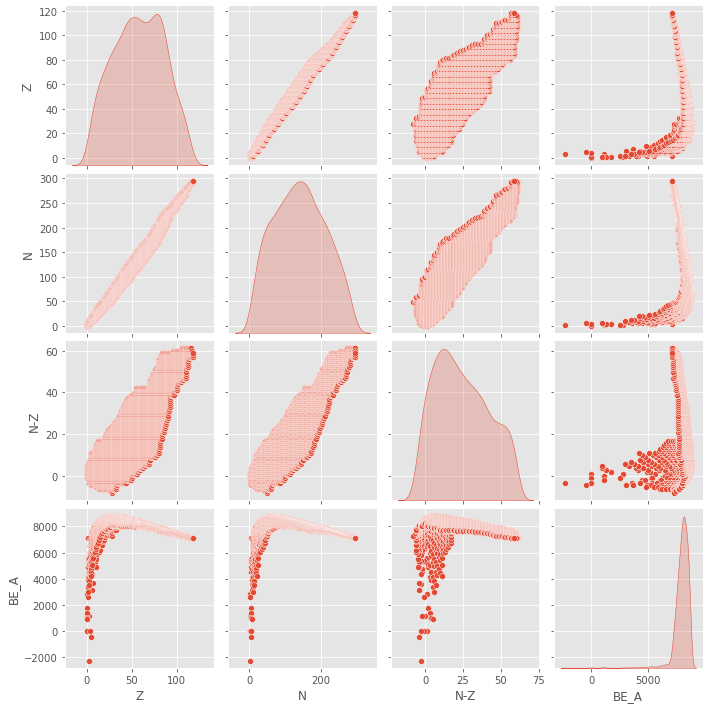

In [310]:
sns.pairplot(test_df[['Z', 'N', 'N-Z', 'BE_A']], diag_kind='kde')

In [327]:
test_df.isna().sum()

Element_Symbol      0
Z                   0
A                   0
N                   0
N-Z                 0
BE_A                0
BE_A_err            0
MassExcess          0
MassExcessErr       0
AtomicMass          0
AtomicMassErr       0
BetaDecayE        295
BetaDecayE_err    295
dtype: int64

In [315]:
test_df = test_df.dropna()

In [333]:
train_dataset = test_df.sample(frac=0.8, random_state=0)
test_dataset = test_df.drop(train_dataset.index)

In [334]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Z,2749.0,5.783630e+01,2.806847e+01,1.000000e+00,3.600000e+01,5.800000e+01,8.000000e+01,1.180000e+02
A,2749.0,8.198690e+01,4.353148e+01,0.000000e+00,4.700000e+01,8.100000e+01,1.140000e+02,1.770000e+02
N,2749.0,1.398232e+02,7.109525e+01,1.000000e+00,8.400000e+01,1.390000e+02,1.940000e+02,2.950000e+02
N-Z,2749.0,2.415060e+01,1.763870e+01,-8.000000e+00,1.000000e+01,2.200000e+01,3.800000e+01,6.100000e+01
BE_A,2749.0,7.945869e+03,7.673857e+02,-2.267000e+03,7.719038e+03,8.066000e+03,8.361059e+03,8.794553e+03
BE_A_err,2749.0,2.014006e+00,1.675891e+01,0.000000e+00,2.500000e-02,9.900000e-02,1.024000e+00,6.670000e+02
MassExcess,2749.0,-2.329751e+04,5.644575e+04,-9.165285e+04,-6.454300e+04,-3.877900e+04,2.329000e+03,2.015120e+05
MassExcessErr,2749.0,1.258043e+02,2.002939e+02,0.000000e+00,3.074000e+00,1.501800e+01,2.000000e+02,2.003000e+03
AtomicMass,2749.0,1.397982e+08,7.112651e+07,1.007825e+06,8.391650e+07,1.389298e+08,1.939654e+08,2.952163e+08
AtomicMassErr,2749.0,1.350340e+02,2.149951e+02,0.000000e+00,3.300000e+00,1.612200e+01,2.150000e+02,2.150000e+03


In [447]:
train_features = train_dataset[['Z', 'N']].copy()
test_features = test_dataset[['Z', 'N']].copy()

train_labels = train_dataset[["BE_A"]].copy()
test_labels = test_dataset[["BE_A"]].copy()

#### Normalization

In [448]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
Z,5.783630e+01,2.806847e+01
A,8.198690e+01,4.353148e+01
N,1.398232e+02,7.109525e+01
N-Z,2.415060e+01,1.763870e+01
BE_A,7.945869e+03,7.673857e+02
BE_A_err,2.014006e+00,1.675891e+01
MassExcess,-2.329751e+04,5.644575e+04
MassExcessErr,1.258043e+02,2.002939e+02
AtomicMass,1.397982e+08,7.112651e+07
AtomicMassErr,1.350340e+02,2.149951e+02


In [484]:
train_features = np.array(train_features)
train_features

array([[ 13,  30],
       [ 79, 209],
       [  2,  10],
       ...,
       [ 22,  43],
       [ 86, 202],
       [  5,  12]], dtype=int64)

In [348]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))

In [487]:
def build_and_compile_model():
    model = keras.Sequential([
        layers.Dense(16, input_shape=(2,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [488]:
dnn_BEA_model = build_and_compile_model()

In [489]:
dnn_BEA_model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_76 (Dense)             (None, 16)                48        
_________________________________________________________________
dense_77 (Dense)             (None, 64)                1088      
_________________________________________________________________
dense_78 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_79 (Dense)             (None, 1)                 65        
Total params: 5,361
Trainable params: 5,361
Non-trainable params: 0
_________________________________________________________________


In [502]:
#plot_model(dnn_BEA_model, to_file='DNN_BEA_Model.png')
#SVG(model_to_dot(dnn_BEA_model).create(prog='dot', format='svg'))

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


AttributeError: 'NoneType' object has no attribute 'create'

In [490]:
%%time
history = dnn_BEA_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=1, epochs=100, batch_size=1)

Epoch 1/100
2199/2199 [==============================] - 6s 3ms/step - loss: 3357.6294 - val_loss: 3028.2678
Epoch 2/100
2199/2199 [==============================] - 5s 2ms/step - loss: 3149.7192 - val_loss: 2939.1328
Epoch 3/100
2199/2199 [==============================] - 5s 2ms/step - loss: 3107.6165 - val_loss: 3142.0825
Epoch 4/100
2199/2199 [==============================] - 5s 2ms/step - loss: 3041.7192 - val_loss: 2860.9031
Epoch 5/100
2199/2199 [==============================] - 5s 2ms/step - loss: 2968.9756 - val_loss: 2770.8240
Epoch 6/100
2199/2199 [==============================] - 5s 2ms/step - loss: 2841.3882 - val_loss: 2522.3391
Epoch 7/100
2199/2199 [==============================] - 5s 2ms/step - loss: 2295.0051 - val_loss: 1267.1182
Epoch 8/100
2199/2199 [==============================] - 5s 2ms/step - loss: 825.1094 - val_loss: 729.2838
Epoch 9/100
2199/2199 [==============================] - 5s 2ms/step - loss: 426.1616 - val_loss: 428.0875
Epoch 10/100
2199/2199 

In [491]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    #plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [Binding Energy/A, keV]')
    plt.legend()
    plt.grid(True)

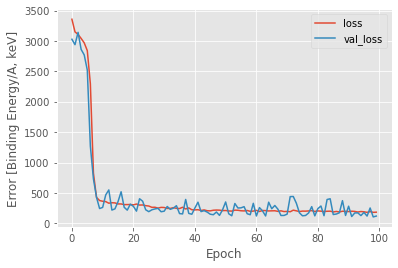

In [492]:
plot_loss(history)

In [493]:
test_results = dnn_BEA_model.evaluate(test_features, test_labels, verbose=0)
test_results

115.23043823242188

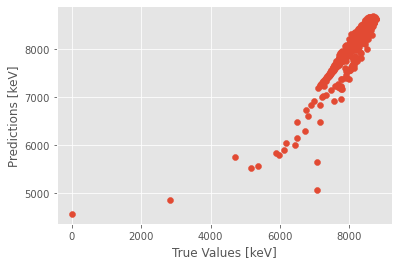

In [494]:
test_predictions = dnn_BEA_model.predict(test_features).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [keV]')
plt.ylabel('Predictions [keV]')
plt.show()

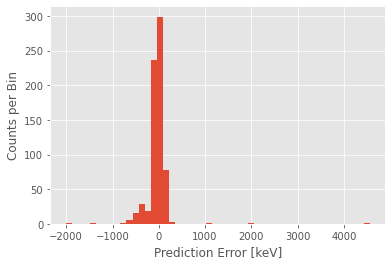

In [495]:
error = np.array(test_predictions).reshape(len(test_predictions),1) - np.array(test_labels)
plt.hist(error, bins=50)
plt.xlabel('Prediction Error [keV]')
plt.ylabel('Counts per Bin')
plt.show()

In [508]:
ugh = np.array([[118],[300]]).reshape(1,2)
#ugh = np.expand_dims(ugh,1) # change shape from (8,) to (1,8)
dnn_BEA_model.predict(ugh, batch_size=1)

array([[7157.618]], dtype=float32)

#### DNN Binding Energy / Nucleon (keV) Estimator Model 2
- Incorporation of (N-Z) into inputs

In [517]:
def BEA_model_v2():
    model = keras.Sequential([
        layers.Dense(16, input_shape=(3,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [518]:
dnn_BEA_model2 = BEA_model_v2()
dnn_BEA_model2.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_84 (Dense)             (None, 16)                64        
_________________________________________________________________
dense_85 (Dense)             (None, 64)                1088      
_________________________________________________________________
dense_86 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_87 (Dense)             (None, 1)                 65        
Total params: 5,377
Trainable params: 5,377
Non-trainable params: 0
_________________________________________________________________


In [511]:
X_train, X_test, y_train, y_test = train_test_split(test_df[['Z','N','N-Z']], test_df["BE_A"], test_size=0.2, random_state=42)

In [519]:
%%time
history = dnn_BEA_model2.fit(
    X_train, y_train,
    validation_split=0.2,
    verbose=1, epochs=100, batch_size=1)

Epoch 1/100
2198/2198 [==============================] - 5s 2ms/step - loss: 3307.4492 - val_loss: 3016.0107
Epoch 2/100
2198/2198 [==============================] - 5s 2ms/step - loss: 2923.0103 - val_loss: 2864.0264
Epoch 3/100
2198/2198 [==============================] - 5s 2ms/step - loss: 2736.4592 - val_loss: 2691.3623
Epoch 4/100
2198/2198 [==============================] - 5s 2ms/step - loss: 2591.9956 - val_loss: 2608.3835
Epoch 5/100
2198/2198 [==============================] - 5s 2ms/step - loss: 2467.9231 - val_loss: 2448.7490
Epoch 6/100
2198/2198 [==============================] - 5s 2ms/step - loss: 2287.4297 - val_loss: 2183.8667
Epoch 7/100
2198/2198 [==============================] - 5s 2ms/step - loss: 2021.6196 - val_loss: 1829.9817
Epoch 8/100
2198/2198 [==============================] - 5s 2ms/step - loss: 1450.2114 - val_loss: 924.4589
Epoch 9/100
2198/2198 [==============================] - 5s 2ms/step - loss: 490.5436 - val_loss: 380.5825
Epoch 10/100
2198/2198

In [520]:
test_results = dnn_BEA_model2.evaluate(X_test, y_test, verbose=1)

22/22 [==============================] - 0s 1ms/step - loss: 102.2939


In [523]:
test_predictions = dnn_BEA_model2.predict(X_test).flatten()

In [530]:
np.array(test_predictions).shape

(688,)

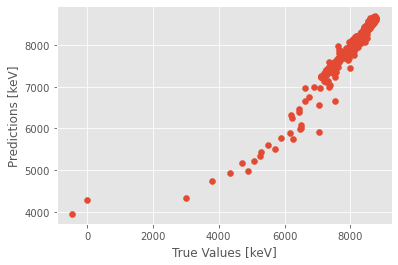

In [525]:
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [keV]')
plt.ylabel('Predictions [keV]')
plt.show()

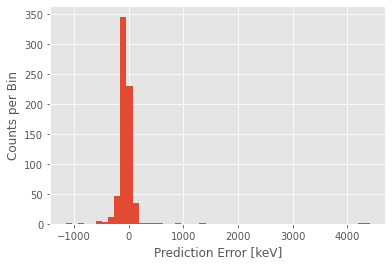

In [531]:
error = np.array(test_predictions).reshape(len(test_predictions),1) - np.array(y_test).reshape(len(y_test),1)
plt.hist(error, bins=50)
plt.xlabel('Prediction Error [keV]')
plt.ylabel('Counts per Bin')
plt.show()

In [534]:
ugh = np.array([[118],[300], [300-118]]).reshape(1,3)
#ugh = np.expand_dims(ugh,1) # change shape from (8,) to (1,8)
dnn_BEA_model2.predict(ugh, batch_size=1)

array([[6553.045]], dtype=float32)